In [1]:
# Inputs: Predictions of models on inconsistent HFOs, in the format of probabilities 
# Outputs: Divides inconsistent HFOs into 5 categories based on their degree of inconsistency, 
# returns average performance of inconsistent HFOs in each of those 5 categories

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
from copy import deepcopy
from sklearn.neighbors import KernelDensity

In [7]:
labelspath = '/home3/ebrahim/TNEC_paper_code/experiment_data/'
predspath = 'unique_overlap_preds/'

In [56]:
ltype = ['A', 'B', 'C']
quarters = np.asarray(['q1', 'q2', 'q3', 'q4'])

pname = ['509', '493', '489', '487']

consis_perf = np.zeros((3,4,4,6)) # 3 total M x 4 patients * 4 training quarters * (3 non-overlapping epochs * 2 alternative M)

num_cat = np.zeros((len(pname), 4))
avg_cat = np.zeros((4))

gc_arr = []
preds_arr = []
preds_int_arr = []
doi_arr = []


# loop through patients 
for j, p in enumerate(pname):
    print(j)

    # loop through training M 
    for o, l in enumerate(ltype):

        c = 0

        if p != '487':
            thresh = .9

        else:
            thresh = .84

        for z, q_train in enumerate(quarters):
            
            # binary performance on consistent HFOs 
            consistent_HFOs = np.mean(np.load(predspath + 'model_' + l + '_' + q_train + '_' + p + '_3_overlap.npy'), axis=-1)
            consis_perf[o, j, z] = consistent_HFOs[consistent_HFOs!=0]

            # load model scores on consistent + inconsistent HFOs  
            model_preds = np.load(predspath + 'model_' + l + '_' + q_train + '_' + p + '_3_unique_preds.npy', allow_pickle=True)
            model_preds_consis = np.load(predspath + 'model_' + l + '_' + q_train + '_' + p + '_3_overlap_preds.npy', allow_pickle=True)
            
            # performance on inconsistent HFOs 
            # this is more complicated because for every testing partition 
            # we have to load the DOI for all inconsistent HFOs
            # divide these inconsistent HFOs into categories based on their DOI 
            # and finally evaluate model performance on each category
            for k, q in enumerate(quarters):

                # if test quarter is overlapping with training quarter, continue
                if q == q_train:
                    continue

                # MM for S2
                for l_test in ltype:

                    # if S2 is marked using the same methodology as S1, there are no inconsistent HFOs so continue
                    if l == l_test:
                        continue

                    # load percentile scores, these are given by MM_R
                    percentile_unq = np.load(labelspath + p + '_d/hfo_' + q + '_' + l_test + '_' + l + '_unique_percentile_labels.npy')
                    percentile_overlap = np.load(labelspath + p + '_d/hfo_' + q + '_' + l_test + '_' + l + '_overlap_percentile_labels.npy')

                    # compute degree of inconsistency (DOI), 0 equals no inconsistency
                    if l == 'A':
                        doi = thresh - np.average(percentile_unq, axis=-1, weights=(1,3,1))
                        gc_arr.append(np.hstack((np.average(percentile_overlap, axis=-1, weights=(1,3,1)), 
                                         np.average(percentile_unq, axis=-1, weights=(1,3,1)))))
                    if l == 'B':
                        doi = thresh - np.average(percentile_unq, axis=-1, weights=(3,1,1))
                        gc_arr.append(np.hstack((np.average(percentile_overlap, axis=-1, weights=(3,1,1)), 
                                         np.average(percentile_unq, axis=-1, weights=(3,1,1)))))
                    if l == 'C':
                        doi = thresh - np.average(percentile_unq, axis=-1, weights=(6,1,1))
                        gc_arr.append(np.hstack((np.average(percentile_overlap, axis=-1, weights=(6,1,1)), 
                                         np.average(percentile_unq, axis=-1, weights=(6,1,1)))))
                        
                    consis_preds = model_preds_consis.item()[q + '_' + l_test]

                    # append 0s of shape consis preds for consistent HFO dois
                    doi_arr.append(np.hstack((np.zeros_like(consis_preds[:,0]), doi)))
                        
                    # model predictions for each HFO in S2 that is inconsistent 
                    preds = model_preds.item()[q + '_' + l_test]
                    
                    # we subtract the consistent class sigmoid output from the inconsistent class sigmoid output
                    preds_arr.append(np.hstack((consis_preds[:,1]-consis_preds[:,0], preds[:,1]-preds[:,0])))

0
1
2
3


In [11]:
def compute_variance_consis_inconsis(doi_numpy, preds_numpy):
    
    doi_zero = np.argwhere(doi_numpy==0)
    doi_nonzero = np.argwhere(doi_numpy!=0)
    print("Standard deviation consistnet: ", np.std(preds_numpy[doi_zero]))
    print("HFO Count consistent: ", preds_numpy[doi_zero].shape)
    print("Standard deviation inconsistnet: ", np.std(preds_numpy[doi_nonzero]))
    print("HFO Count inconsistent: ", preds_numpy[doi_nonzero].shape)

In [80]:
f= [1.2, .9, .6, .3]
def make_doi_plots(doi_arr, preds_arr, gc_arr, int_mode, savefig=False):
    
    sns.set_style('white')
    
    f= [1.2, .9, .6, .3] # for different colored lines for each patient
    fig, ax = plt.subplots(2,2,figsize=(10,8))
    c = 0
    bin_arr = np.arange(-.01, .2, .01)  
    
    for p in range (2):
        for p2 in range (2):
        
            # select data for a single patient 
            doi_arr_patient = doi_arr[c*6:(c+1)*6]
            preds_arr_patient = preds_arr[c*6:(c+1)*6]
            gc_arr_patient = gc_arr[c*6:(c+1)*6]
    
            doi_numpy = np.hstack((doi_arr_patient))
            preds_numpy = np.hstack((preds_arr_patient))
            
            np.savetxt('data_for_figures/figure_2_f_g_preds_patient_' + str(c+1) + '.csv', preds_numpy, delimiter=',')
            gc_numpy = np.hstack((gc_arr_patient))
            
            #compute_variance_consis_inconsis(doi_numpy, preds_numpy)
            
            # integer mode, predictions are converted into a binary array 
            if int_mode:
                preds_numpy[preds_numpy>0]=1
                preds_numpy[preds_numpy!=1]=0
                consis_preds = np.argwhere(preds_numpy==1)
                inconsis_preds = np.argwhere(preds_numpy==0)

                doi_numpy_graphical = deepcopy(doi_numpy)
                doi_numpy_graphical[doi_numpy_graphical==0] = -.01 # for plotting purposes only

                # compute fraction of inconsistent class predictions (by network) for each DOI bin
                consis_pred_dois = doi_numpy_graphical[consis_preds]
                inconsis_pred_dois = doi_numpy_graphical[inconsis_preds]

                hist_consis, bins_consis = np.histogram(consis_pred_dois, bins=bin_arr)
                hist_inconsis, bins_inconsis = np.histogram(inconsis_pred_dois, bins=bin_arr)
                frac_inconsis = hist_inconsis / (hist_inconsis+hist_consis)
                
                # values presented in paper
                print("PARTICIPANT NUMBER: ", c+1)
                print("Fraction inconsistent: ", frac_inconsis[1])
                print("N: ", hist_inconsis[1])
                print("DOI BINS: ", bins_inconsis[1:3])


                n, bins, patches = ax[p, p2].hist(doi_numpy_graphical, color=(.4, .8, .7), log=True, bins=bin_arr, 
                                  edgecolor='white', alpha=.6)

                patches[0].set_facecolor(color=(.3, .3, .3))
                for j in range(1,len(bins)-1,1):
                    patches[j].set_facecolor(color=(.6, .6, .6))

                ax[p, p2].set_xlim(bin_arr[0]-.01, .3)
                ax[p, p2].set_xticks([0, .1])
                
                if p == 1:
                    ax[p, p2].set_xlabel("DOI", fontsize=16)

                if p2 == 0:
                    ax[p, p2].set_ylabel("HFO Count", fontsize=16)

                ax2 = ax[p, p2].twinx() 
                ax2.axhline(.4, color='b')
                ax2.plot(bins_inconsis[:-1]+.005, frac_inconsis, marker='o', markersize=6, color=(.4*f[c], .8*f[c], .7*f[c]), linewidth=3)
                ax2.set_ylim(0,1.05)
                ax2.set_yticks(np.arange(0,1,.1))
                ax2.plot()
                  
            # for making DOI graphs w/o sigmoid score output
            else:
                sns.despine()
                ax[p, p2].set_ylim(-.05,1.05)
                ax[p, p2].set_xlim(0, 1.05)

                pear, pval = pearsonr(doi_numpy, preds_numpy)

                sns.regplot(x=doi_numpy[doi_numpy!=0], y=preds_numpy[doi_numpy!=0], truncate=True, 
                            scatter_kws={'color':(.4*f[c], .8*f[c], .7*f[c]), 'edgecolor':'white', 'alpha':.8},
                            line_kws = {'color':(0,0,0)}, ci=None, order=1,
                                ax=ax[p, p2])
                if p2==0:
                    ax[p,p2].set_yticks([0, 1])
                    ax[p,p2].set_ylabel("Network output", fontsize=16)
                else:
                    ax[p,p2].set_yticks([])
                if p==1:
                    ax[p,p2].set_xticks([0, .5, 1])
                    ax[p,p2].set_xlabel("DOI", fontsize=16)
                else:
                    ax[p,p2].set_xticks([])

            c+=1

    if savefig: 
        if int_mode:
            plt.savefig('Consistency_Figures_pdf/doi_within.pdf', dpi=400, bbox_inches='tight', format='pdf')
            plt.savefig('Consistency_Figures_png/doi_within', dpi=400, bbox_inches='tight')
        else:
            plt.savefig('Consistency_Figures_pdf/sigmoid_within.pdf', dpi=400, bbox_inches='tight', format='pdf')
            plt.savefig('Consistency_Figures_png/sigmoid_within', dpi=400, bbox_inches='tight')
        plt.show()

PARTICIPANT NUMBER:  1
Fraction inconsistent:  0.3362549800796813
N:  422
DOI BINS:  [0.   0.01]
PARTICIPANT NUMBER:  2
Fraction inconsistent:  0.3427091043671355
N:  463
DOI BINS:  [0.   0.01]
PARTICIPANT NUMBER:  3
Fraction inconsistent:  0.2688679245283019
N:  342
DOI BINS:  [0.   0.01]
PARTICIPANT NUMBER:  4
Fraction inconsistent:  0.3214562354763749
N:  415
DOI BINS:  [0.   0.01]


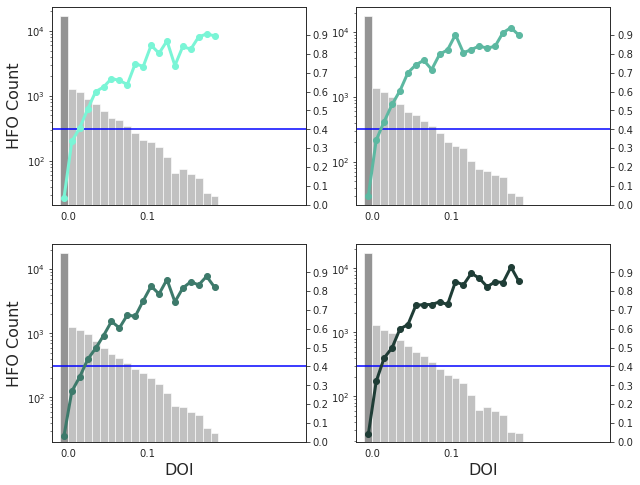

In [81]:
make_doi_plots(doi_arr, preds_arr, gc_arr, int_mode=True)

In [7]:
def plot_inconsistent_HFO_perf(consis_perf, cat1, cat2, cat3, cat4, setting):
    
    x = np.asarray([0, .0075, .03, .0675, .2])
    
    if setting==0:
        title = ''
        ylabel = '% consistent predictions '
        start=0
        f=100
        save_name = 'inconsistent_HFOs'
    elif setting==1:
        title = "Within patient network"
        ylabel = 'Mean sigmoid score '
        start=1
        f=1
        save_name = 'sigmoid_inconsistent_HFOs'
        
    mean_cat1 = np.nanmean(cat1,axis=(0,2))
    mean_cat2 = np.nanmean(cat2,axis=(0,2))
    mean_cat3 = np.nanmean(cat3,axis=(0,2))
    mean_cat4 = np.nanmean(cat4,axis=(0,2))
    mean_consis = np.nanmean(consis_perf, axis=(0,2,3))
    
    std_cat1 = np.nanstd(cat1,axis=(0,2))
    std_cat2 = np.nanstd(cat2,axis=(0,2))
    std_cat3 = np.nanstd(cat3,axis=(0,2))
    std_cat4 = np.nanstd(cat4,axis=(0,2))
    std_consis = np.nanstd(consis_perf, axis=(0,2,3))
    
    jitter1 = 3e-2
    jitter2 = 1.5e-2
    
    cat_509_mean = np.asarray([mean_consis[0] + jitter1, mean_cat1[0], mean_cat2[0], mean_cat3[0], mean_cat4[0]])
    cat_509_std = [std_consis[0], std_cat1[0], std_cat2[0], std_cat3[0], std_cat4[0]]
    
    cat_493_mean = np.asarray([mean_consis[1] + jitter2, mean_cat1[1], mean_cat2[1], mean_cat3[1], mean_cat4[1]])
    cat_493_std = np.asarray([std_consis[1], std_cat1[1], std_cat2[1], std_cat3[1], std_cat4[1]])
    
    cat_489_mean = np.asarray([mean_consis[2], mean_cat1[2], mean_cat2[2], mean_cat3[2], mean_cat4[2]])
    cat_487_mean = np.asarray([mean_consis[3], mean_cat1[3], mean_cat2[3], mean_cat3[3], mean_cat4[3]])
    
    
    fig, ax = plt.subplots(1,1, figsize=(6,3))
    sns.set_theme()
    sns.set_style('white')
    sns.despine()
    
    ax.plot(x[start:], cat_509_mean[start:]*f, '-', marker='o', label='Patient 1', linewidth=3, markersize=10, color=(.4*1.2,.8*1.2,.7*1.2))    
    ax.plot(x[start:], cat_493_mean[start:]*f, '-', marker='o',  label='Patient 2', linewidth=3, markersize=10, color=(.4*.9,.8*.9,.7*.9))  
    ax.plot(x[start:], cat_489_mean[start:]*f, 'o-', label='Patient 3', linewidth=3, markersize=10, color=(.4*.6,.8*.6,.7*.6))
    ax.plot(x[start:], cat_487_mean[start:]*f, '-', marker='o', label='Patient 4', linewidth=3, markersize=10 , color=(.4*.3,.8*.3,.7*.3))
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_ylabel(ylabel, fontsize=15)
    ax.set_xlabel('Degree of inconsistency (DOI)', fontsize=15)
    if setting==1:
        ax.axhline(.5, linestyle='--')
    plt.legend()
    ax.set_title(title, fontsize=17)
    ax.set_xticks([.2, .1, 0])
    ax.set_yticks([0, .5*f, 1*f])
    ax.set_ylim(0,f*1.05)
    
    return stdcat1, stdcat2, stdcat3, stdcat4, std_consis

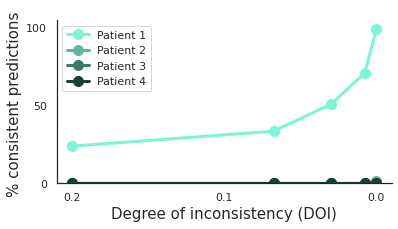

In [16]:
plot_inconsistent_HFO_perf(consis_perf, cat1_perf, cat2_perf, cat3_perf, cat4_perf, setting)

In [ ]:
print(cat1_perf.shape)

In [ ]:
def plot_heatmap(doi_arr, epochs, title):
    
    fig, ax = plt.subplots(2,1,figsize=(8,13))
    plt.subplots_adjust(hspace = .3)

    plt.suptitle(title, fontsize=30) 
    
    ltype_test = np.delete(ltype, ind)
    
    for i in range(2):
        sns.heatmap(doi_arr[:, i, :], annot=True, vmin=0, vmax=.1, cmap='GnBu', annot_kws={"fontsize":15}, ax=ax[i])
        ax[i].set_yticks(np.arange(4)+.5)
        ax[i].set_yticklabels(np.arange(1,5,1), fontsize=20)
        ax[i].set_xticklabels(epochs, fontsize=20)
        ax[i].set_ylabel("Patient", fontsize=24, labelpad=7)
        ax[i].set_xlabel(ltype_test[i], fontsize=24)
        
    plt.savefig("Consistency_Figures/" + title, bbox_inches='tight', dpi=400)
    plt.show()
    
        
    
    